# Tissue Detection

**Overview:** 
This includes tools to detect tissue from an item (slide) using its thumbnail. The basic functionality includes a series of gaussian smoothing and otsu thresholding steps to detect background versus foreground pixels. Optionally, an initial step is performed whereby color deconvolution is used to deparate hematoxylin and eosin stains (assuming H&E stained slides) to make sure only cellular areas are segmented. This proves to be useful in getting rid of sharpie markers. A size threshold is used to keep only largest contiguous tissue regions.


![tissuedetectionMethod](https://user-images.githubusercontent.com/22067552/80084299-af06d980-8524-11ea-9521-a3ec48253dfc.png)
**Where to look?**

```
|_ histomicstk/
  |_saliency/
     |_tissue_detection.py 
     |_tests/
        |_test_saliency.py
```

In [1]:
import girder_client
import numpy as np
from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)

%matplotlib inline

## Constants and Prepwork

In [2]:
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
# SAMPLE_SLIDE_ID = '5d586d57bd4404c6b1f28640'
SAMPLE_SLIDE_ID = "5d817f5abd4404c6b1f744bb"

gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
_ = gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

### First, let's fetch the slide thumbnail

In [3]:
thumbnail_rgb = get_slide_thumbnail(gc, SAMPLE_SLIDE_ID)

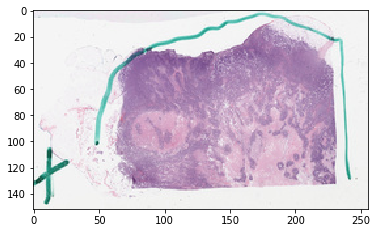

In [4]:
plt.imshow(thumbnail_rgb)

### (Optional) Color normalization of thumbnail

See documentation for ``color_normalization`` module.

## Now we fetch the tissue mask

### This is the method you want to use

In [5]:
print(get_tissue_mask.__doc__)

Get binary tissue mask from slide thumbnail.

    Parameters
    -----------
    thumbnail_rgb : np array
        (m, n, 3) nd array of thumbnail RGB image
    deconvolve_first : bool
        use hematoxylin channel to find cellular areas?
        This will make things ever-so-slightly slower but is better in
        getting rid of sharpie marker (if it's green, for example).
        Sometimes things work better without it, though.
    stain_matrix_method : str
        see deconv_color method in seed_utils
    n_thresholding_steps : int
        number of gaussian smoothign steps
    sigma : float
        sigma of gaussian filter
    min_size : int
        minimum size (in pixels) of contiguous tissue regions to keep

    Returns
    --------
    np bool array
        largest contiguous tissue region.
    np int32 array
        each unique value represents a unique tissue region
    


### Get the tissue masks

In [6]:
labeled, mask = get_tissue_mask(
    thumbnail_rgb, deconvolve_first=True,
    n_thresholding_steps=2, sigma=0., min_size=30)

/home/mtageld/Desktop/HistomicsTK/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


### Visualize the result

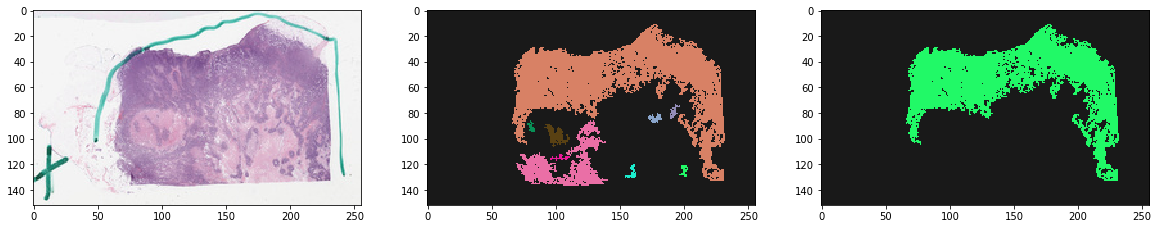

In [7]:
vals = np.random.rand(256,3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)

f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(thumbnail_rgb)
ax[1].imshow(labeled, cmap=cMap) # all tissue regions
ax[2].imshow(mask, cmap=cMap) # largest tissue region
plt.show()

## Note effect of hyperparameters

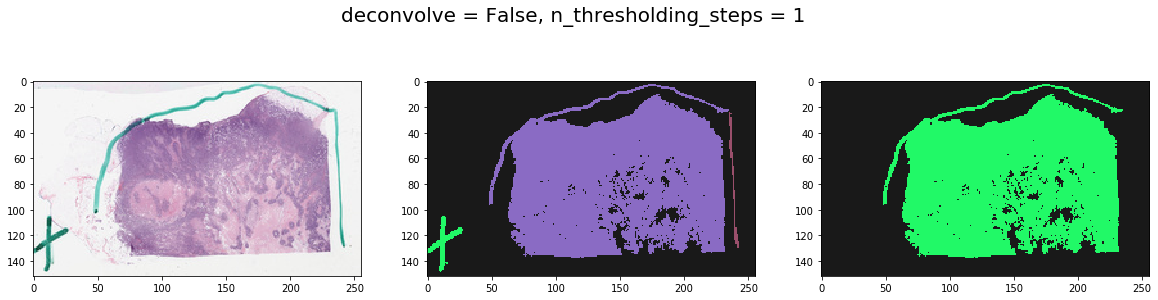

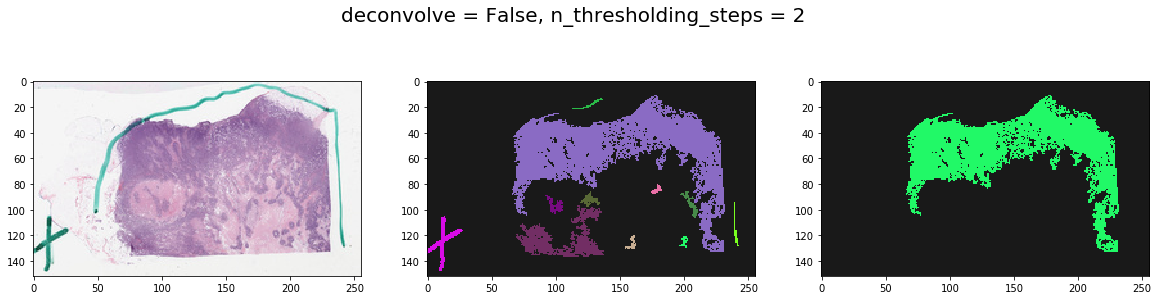

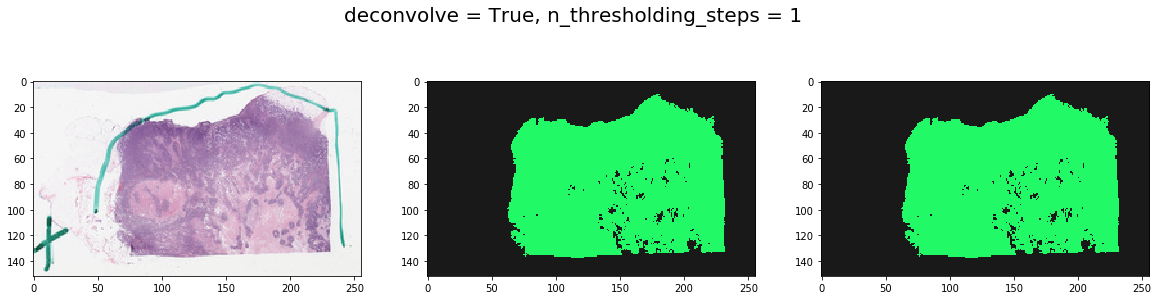

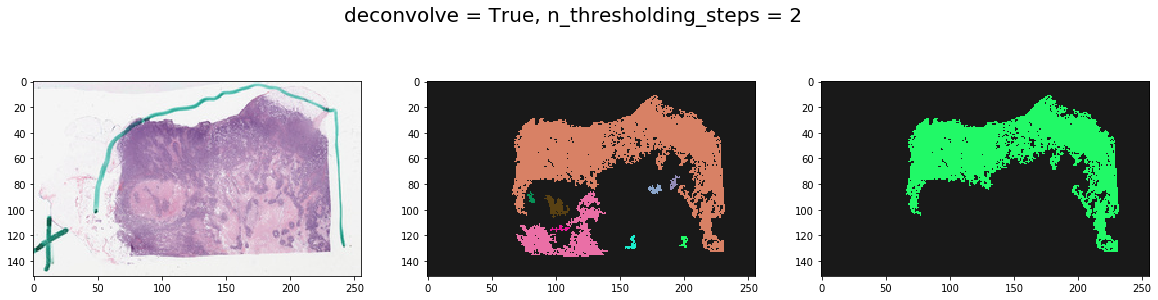

In [8]:
for deconvolve_first in [False, True]:
    for n_thresholding_steps in [1, 2]:

        labeled, mask = get_tissue_mask(
            thumbnail_rgb, deconvolve_first=deconvolve_first,
            n_thresholding_steps=n_thresholding_steps, sigma=0., min_size=30)

        f, ax = plt.subplots(1, 3, figsize=(20, 5))
        ax[0].imshow(thumbnail_rgb)
        ax[1].imshow(labeled, cmap=cMap)
        ax[2].imshow(mask, cmap=cMap)
        plt.suptitle("deconvolve = %s, n_thresholding_steps = %d" % (deconvolve_first, n_thresholding_steps), fontsize=20)
        plt.show()